In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
from rubin_scheduler.scheduler.utils import SkyAreaGenerator
%matplotlib inline

/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calculate_qso_numbers(baseline, nside, maps, outdir, ourdir_db):
    """
    Calculate QSO numbers for different filters.

    Parameters:
    baseline (str): Path to the baseline database file.
    nside (int): HEALPix resolution parameter.
    maps (array): Array of HEALPix IDs to use.
    outdir (str): Output directory for results.
    ourdir_db (str): Directory for results database.

    Returns:
    dict: Metric bundles for each filter.
    """
    baseline_file = baseline
    run_name = os.path.split(baseline_file)[-1].replace('.db', '')
    bundles = {}
    dustmap = maf.DustMap(nside=nside)
    slicer = maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=maps)
    for f in ('u', 'g', 'r', 'i', 'z', 'y'):
        metric = maf.QSONumberCountsMetric(f, zmax=6.7)
        sql = f'filter = "{f}"'
        bundle = maf.MetricBundle(metric, slicer, sql, run_name=run_name, maps_list=[dustmap], info_label=f'{f} band')
        bundles[f] = bundle

    results_db = maf.db.ResultsDb(out_dir=ourdir_db)
    bundle_group = maf.MetricBundleGroup(bundles, baseline_file, out_dir=outdir, results_db=results_db)
    bundle_group.run_all()
    return bundles

def calculate_total_qsos(bundles):
    """
    Calculate the total number of QSOs for each filter.

    Parameters:
    bundles (dict): Metric bundles for each filter.

    Returns:
    dict: Total number of QSOs for each filter.
    """
    total_qsos_per_band = {}
    summary = maf.SumMetric(col='metric', metric_name='Total QSO')
    
    for f in ('u', 'g', 'r', 'i', 'z', 'y'):
        bundles[f].set_summary_metrics([summary])
        bundles[f].compute_summary_stats()
        total_qsos = bundles[f].summary_values['Total QSO']
        total_qsos_per_band[f] = total_qsos
        print(f'Total QSO count in {f} band: {total_qsos}')
    
    return total_qsos_per_band


In [ ]:
def run_db(baseline):
    nside = 64
    outdir = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Other_Cadence'
    ourdir_db = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Other_Cadence'
    survey_areas = SkyAreaGenerator(nside=nside)
    map_footprints, map_labels = survey_areas.return_maps()

    # Select HEALPix IDs for specific regions
    # ['','LMC_SMC','bulge','dusty_plane','lowdust','nes','scp','virgo']
    maps = np.where(
        (map_labels == 'LMC_SMC') |
        (map_labels == 'bulge') |
        (map_labels == 'dusty_plane') |
        (map_labels == '') |
        (map_labels == 'lowdust') |
        (map_labels == 'nes') |
        (map_labels == 'scp') |
        (map_labels == 'virgo')
    )[0]
    NQSO_bundles = calculate_qso_numbers(baseline, nside, maps, outdir, ourdir_db)
    return 0
bd_files = [f for f in os.listdir("/home/idies/workspace/Temporary/LiGuodong/scratch/maf_data/")if f.endswith('.db')]
dir_path = '/home/idies/workspace/Temporary/LiGuodong/scratch/maf_data/'
for i in bd_files:
    baseline = dir_path+i
    try:
        run_db(baseline)
    except:
        pass

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [3]:
import re
from rubin_sim.maf import MetricBundle, MetricBundleGroup

def find_npz_files(directory):
    """
    Find all .npz files in the given directory and its subdirectories.
    
    Parameters:
    directory (str): The directory to search for .npz files.
    
    Returns:
    list: A list of file paths to .npz files.
    """
    npz_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".npz"):
                npz_files.append(os.path.join(root, file))
    return npz_files

def calculate_total_qsos_band(bundle):
    
    summary = maf.SumMetric(col='metric', metric_name='Total QSO')
    bundle.set_summary_metrics([summary])
    bundle.compute_summary_stats()
    total_qsos = bundle.summary_values['Total QSO']
    return total_qsos

def save_result(outdir):
    MAFOutdir = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/Other_Cadence'
    file_names = find_npz_files(MAFOutdir)
    
    # Extract baseline names from file names
    baseline = set()
    for file_name in file_names:
        match = re.match(r'.*/(.*?QSONumberCountsMetric)', file_name)
        if match:
            baseline.add(match.group(1))
    baseline = list(baseline)
    data = {}
    data['db'] = baseline
    for f in ('u', 'g', 'r', 'i', 'z', 'y'):
        db_data = []
        for db in baseline:
            file_npz = os.path.join(MAFOutdir, f'{db}_{f}_band_HEAL.npz')
            bundle = MetricBundle.load(file_npz)
            total_qso = calculate_total_qsos_band(bundle)
            db_data.append(total_qso)
        data[f] = db_data
    df = pd.DataFrame(data)
    df.to_csv('QSONumberCounts.csv', index=None)
    return 0

outdir = './'
save_result(outdir)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

0

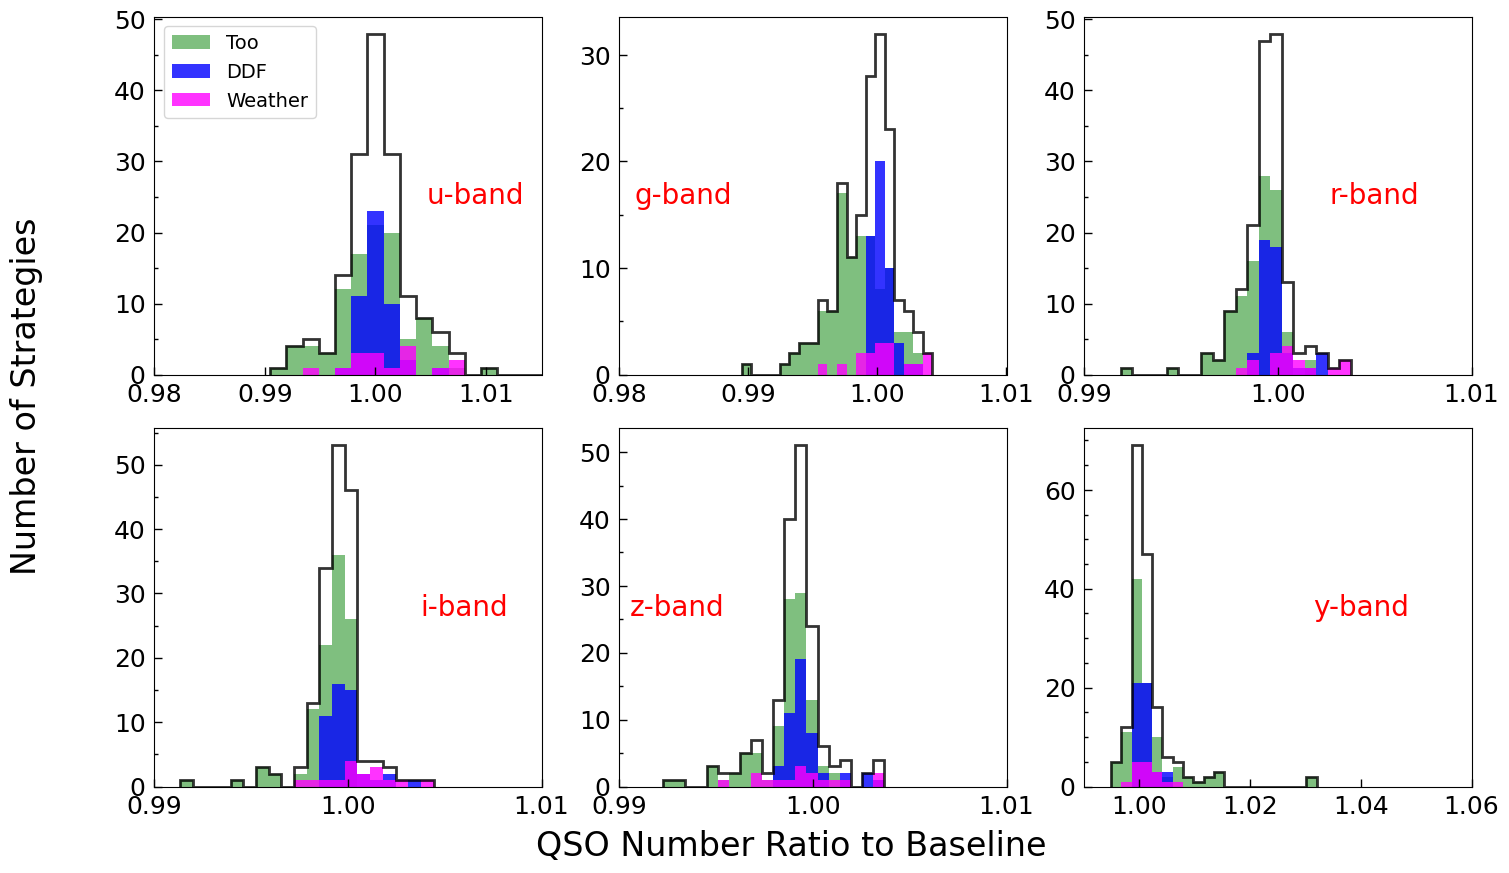

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import colorcet as cc
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

df = pd.read_csv('./QSONumberCounts.csv').set_index('db').sort_index()

filter_band=['u','g','r','i','z','y']
fig, axs = plt.subplots(2, 3, figsize=(17, 10),
                        gridspec_kw={'wspace': 0.2, 'hspace': 0.15})
axs = axs.flatten()
colors = cc.glasbey[:3]
colors = ['magenta','blue','g']
Too = df[df.index.str.contains('too')]
Weather = df[df.index.str.contains('weather')]
DDF = df[df.index.str.contains('ddf')]

for i in range(6):
    data = df[filter_band[i]]/df[filter_band[i]]['baseline_v3_4_10yrs_QSONumberCountsMetric']
    n, bins, patches = axs[i].hist(data, bins=20, edgecolor='black', alpha=0.8, histtype='step', linewidth=2)
    
    data_too = Too[filter_band[i]]/df[filter_band[i]]['baseline_v3_4_10yrs_QSONumberCountsMetric']
    axs[i].hist(data_too, bins=bins, color=colors[2], alpha=0.5, label='Too')
    
    data_DDF = DDF[filter_band[i]]/df[filter_band[i]]['baseline_v3_4_10yrs_QSONumberCountsMetric']
    axs[i].hist(data_DDF, bins=bins, color=colors[1], alpha=0.8, label='DDF')
    
    data_weather = Weather[filter_band[i]]/df[filter_band[i]]['baseline_v3_4_10yrs_QSONumberCountsMetric']
    axs[i].hist(data_weather, bins=bins, color=colors[0], alpha=0.8, label='Weather')

    
    if i==5:
        xmajorLocator = MultipleLocator(0.02)
        ymajorLocator = MultipleLocator(20)
        yminorLocator = MultipleLocator(5)
    else:
        xmajorLocator = MultipleLocator(0.01)
        ymajorLocator = MultipleLocator(10)
        yminorLocator = MultipleLocator(5)
    axs[i].yaxis.set_major_locator(ymajorLocator)
    axs[i].yaxis.set_minor_locator(yminorLocator)
    axs[i].xaxis.set_major_locator(xmajorLocator)
    axs[i].tick_params(axis='both',which='major',tickdir='in',labelsize=18,width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    axs[i].tick_params(axis='both',which='minor',tickdir='in',width=1,length=3,bottom=True, top=False, left=True, right=False)
axs[0].legend(fontsize=14,loc='upper left')
axs[0].set_xlim(0.98,1.015)
axs[1].set_xlim(0.98,1.01)
axs[2].set_xlim(0.99,1.01)
axs[3].set_xlim(0.99,1.01)
axs[4].set_xlim(0.99,1.01)
axs[5].set_xlim(0.99,1.06)

y_max1 = axs[0].get_ylim()[1]
y_max2 = axs[1].get_ylim()[1]
y_max3 = axs[2].get_ylim()[1]
y_max4 = axs[3].get_ylim()[1]
y_max5 = axs[4].get_ylim()[1]
y_max6 = axs[5].get_ylim()[1]
axs[0].text(1.009, 0.5*y_max1, 'u-band', color='r', fontsize=20, verticalalignment='center', horizontalalignment='center')
axs[1].text(0.985, 0.5*y_max2, 'g-band', color='r', fontsize=20, verticalalignment='center', horizontalalignment='center')
axs[2].text(1.005, 0.5*y_max3, 'r-band', color='r', fontsize=20, verticalalignment='center', horizontalalignment='center')
axs[3].text(1.006, 0.5*y_max4, 'i-band', color='r', fontsize=20, verticalalignment='center', horizontalalignment='center')
axs[4].text(0.993, 0.5*y_max5, 'z-band', color='r', fontsize=20, verticalalignment='center', horizontalalignment='center')
axs[5].text(1.04, 0.5*y_max6, 'y-band', color='r', fontsize=20, verticalalignment='center', horizontalalignment='center')

fig.text(0.5, 0.05, r'QSO Number Ratio to Baseline', ha='center', va='center', fontsize=24)
fig.text(0.05, 0.5, 'Number of Strategies', ha='center', va='center', rotation='vertical', fontsize=24)
plt.show()